In [3]:
!pip uninstall -y torchvision # Uninstall since it was not working correctly

Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2


In [3]:
!pip install rapidfuzz

import re, unicodedata
import pandas as pd
from rapidfuzz import process, fuzz


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.2 MB/s  0:00:00


In [7]:
# =====================================
# Cell 1 — Imports & Setup
# =====================================
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity

tqdm.pandas()

# Paths
USER_CSV = "complete_imdb_user_reviews.csv"
USER_OUT = "user_emotions_simple.csv"

# Emotion labels in this model
EMO_COLS = ["anger","disgust","fear","joy","neutral","sadness","surprise"]


In [8]:
# =====================================
# Cell 2 — Load HuggingFace pipelines
# =====================================
sent_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

emo_pipe = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [9]:
# =====================================
# Cell 3 — Inference Function (single review)
# =====================================
def infer(text: str):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {**{e: 0.0 for e in EMO_COLS},
                "sentiment_score": 0.0,
                "sentiment_label": "NEUTRAL"}
    
    snippet = text[:512]  # model token limit
    s = sent_pipe(snippet)[0]
    e = emo_pipe(snippet)[0]

    emo = {x["label"].lower(): float(x["score"]) for x in e}
    emo["sentiment_label"] = s["label"]
    emo["sentiment_score"] = s["score"] * (1 if s["label"]=="POSITIVE" else -1)
    return emo


In [10]:
# =====================================
# Cell 4 — Apply to User Reviews
# =====================================
df = pd.read_csv(USER_CSV)
df = df[df["review_text"].astype(str).str.strip().ne("")].reset_index(drop=True)

# Parse clean movie title
def parse_title_year(s: str):
    m = re.search(r'^(.*?)\s*\((\d{4})\)', str(s))
    return (m.group(1).strip(), int(m.group(2))) if m else (s.strip(), np.nan)

df["movie_clean"], df["year"] = zip(*df["movie_title"].apply(parse_title_year))

# Run inference
df["emo_dict"] = df["review_text"].progress_map(infer)

# Flatten dictionary columns
emo_df = pd.json_normalize(df["emo_dict"])
df = pd.concat([df, emo_df], axis=1)


100%|███████████████████████████████████████| 6215/6215 [21:15<00:00,  4.87it/s]


In [15]:
len(df['movie_clean'].unique())

250

In [16]:
# =====================================
# Cell 5 — Aggregate per Movie
# =====================================
agg = (
    df.groupby(["movie_clean"], as_index=False)
      .agg({**{c:"mean" for c in EMO_COLS},
            "sentiment_score":"mean",
            "user_rating":"mean"})
      .rename(columns={"user_rating":"avg_user_rating"})
)

# Dominant emotion
def dominant(row):
    vals = row[EMO_COLS].to_numpy()
    i = int(np.argmax(vals))
    return pd.Series({"dominant_emotion": EMO_COLS[i], "dominant_strength": vals[i]})

dom = agg.apply(dominant, axis=1)
agg = pd.concat([agg, dom], axis=1)

agg.to_csv(USER_OUT, index=False)
print(f"Saved {USER_OUT} with {len(agg)} movies")


Saved user_emotions_simple.csv with 250 movies


        movie_clean     anger   disgust      fear       joy   neutral  \
0      12 Angry Men  0.128143  0.084339  0.068933  0.093981  0.439152   
1  12 Years a Slave  0.094523  0.247110  0.117163  0.071865  0.271172   
2         12th Fail  0.027739  0.054155  0.029398  0.414248  0.266727   

    sadness  surprise  sentiment_score  avg_user_rating dominant_emotion  \
0  0.017692  0.167760         0.613828         9.318182          neutral   
1  0.091981  0.106187         0.435089         8.130435          neutral   
2  0.108101  0.099632         0.765803         9.240000              joy   

   dominant_strength  
0           0.439152  
1           0.271172  
2           0.414248  

Average Sentiment Score Range: -0.15730519344409308 → 0.9724580883979798
Correlation between user rating and sentiment: 0.340


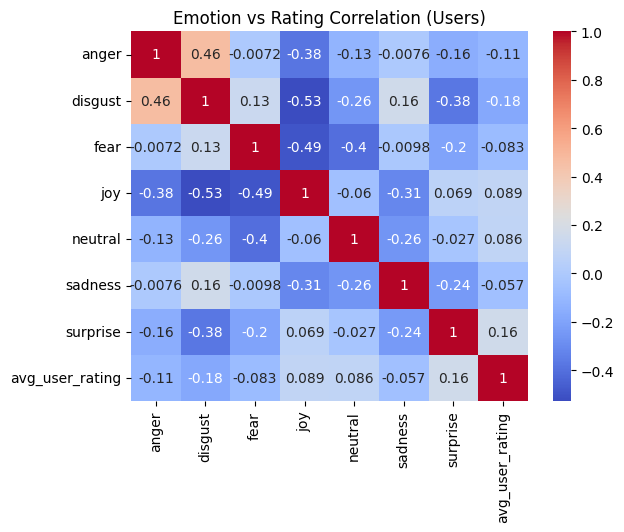

In [17]:
# =====================================
# Cell 6 — Sanity Check
# =====================================
print(agg.head(3))
print("\nAverage Sentiment Score Range:", agg["sentiment_score"].min(), "→", agg["sentiment_score"].max())

# Correlation between rating & sentiment
corr = agg["avg_user_rating"].corr(agg["sentiment_score"])
print(f"Correlation between user rating and sentiment: {corr:.3f}")

# Optional: emotion–rating heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(agg[EMO_COLS + ["avg_user_rating"]].corr(), annot=True, cmap="coolwarm")
plt.title("Emotion vs Rating Correlation (Users)")
plt.show()


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def compress_with_tfidf(text, keep_ratio=0.3, max_features=5000):
    """Return a shortened version that keeps start/end and top-TFIDF mid-sentences."""
    sents = re.split(r'(?<=[.!?])\s+', text)
    if len(sents) <= 3:
        return text  # nothing to compress

    start = sents[:2]
    end = sents[-2:]

    mid = sents[2:-2]
    if not mid:
        return text

    # TF-IDF to rank mid sentences
    vec = TfidfVectorizer(max_features=max_features, stop_words="english")
    X = vec.fit_transform(mid)
    tfidf_scores = np.asarray(X.sum(axis=1)).ravel()
    k = max(1, int(len(mid) * keep_ratio))
    top_idx = np.argsort(tfidf_scores)[-k:]
    top_mid = [mid[i] for i in sorted(top_idx)]

    compressed = " ".join(start + top_mid + end)
    return compressed


In [43]:
# =====================================
# Cell A — Critics: Load → TF-IDF Compress → Infer → Aggregate
# =====================================
import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

CRITIC_WIDE = "Critic_Review_Compiled.xlsx"   # <- your critics file
CRITIC_OUT  = "critic_emotions_simple.csv"    # <- output

# 0) Load critics (wide: movie column + columns 1..10 or similar)
crit_raw = pd.read_excel(CRITIC_WIDE)

crit_raw["movie_clean"], crit_raw["year"] = zip(*crit_raw["movie_title"].apply(parse_title_year))


# 1) Melt wide → long
value_cols = [c for c in crit_raw.columns if c != 'movie_clean']
crit_long = (
    crit_raw.melt(id_vars='movie_clean', value_vars=value_cols,
                  var_name="review_id", value_name="review_text")
            .dropna(subset=["review_text"])
            .reset_index(drop=True)
)

# 2) Light cleaning: collapse whitespace, strip quotes
def _clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\u00a0", " ")
    s = re.sub(r"\s+", " ", s).strip().strip('"').strip("'")
    return s

crit_long["review_text"] = crit_long["review_text"].map(_clean_text)

# Keep reasonably informative rows (avoid tiny blurbs)
crit_long = crit_long[crit_long["review_text"].str.len() >= 40].reset_index(drop=True)

print("Critic rows:", len(crit_long), " | Unique movies:", crit_long['movie_clean'].nunique())

# ---- 3) TF-IDF hybrid compression (keep start/end + salient mid) ----
# Uses your previously-defined: compress_with_tfidf(text, keep_ratio=0.3, max_features=5000)
# If not defined, we fall back to original text.
try:
    _ = compress_with_tfidf  # probe
    USE_COMPRESS = True
except NameError:
    USE_COMPRESS = False
    print("NOTE: compress_with_tfidf not found; using full text for inference.")

if USE_COMPRESS:
    # adjust keep_ratio if you want more/less middle kept
    crit_long["review_text_comp"] = crit_long["review_text"].progress_map(
        lambda t: compress_with_tfidf(t, keep_ratio=0.3, max_features=5000)
    )
    # Optional: drop over-compressed very short results
    crit_long = crit_long[crit_long["review_text_comp"].str.len() >= 40].reset_index(drop=True)
    infer_text_col = "review_text_comp"
else:
    infer_text_col = "review_text"

# Optional: quick compression stats
if USE_COMPRESS:
    orig_len = crit_long["review_text"].str.len()
    comp_len = crit_long["review_text_comp"].str.len()
    print(f"Compression ratio (median): {(comp_len / orig_len).median():.2f}")
    print(f"Compression ratio (mean)  : {(comp_len / orig_len).mean():.2f}")

# 4) Run your existing infer() (sentiment + emotion) — assumes it's already defined
crit_long["emo_dict"] = crit_long[infer_text_col].progress_map(infer)

# 5) Flatten + aggregate to per-movie
emo_flat = pd.json_normalize(crit_long["emo_dict"])
crit_flat = pd.concat([crit_long[['movie_clean']], emo_flat], axis=1)

# EMO_COLS must already be defined in your notebook
agg_crit = (
    crit_flat.groupby('movie_clean', as_index=False)
             .agg({**{c:"mean" for c in EMO_COLS}, "sentiment_score":"mean"})
)

# Dominant emotion
def _dominant(row):
    vals = row[EMO_COLS].to_numpy(dtype=float)
    if np.isnan(vals).all():
        return pd.Series({"dominant_emotion": np.nan, "dominant_strength": np.nan})
    i = int(np.nanargmax(vals))
    return pd.Series({"dominant_emotion": EMO_COLS[i], "dominant_strength": vals[i]})

dom = agg_crit.apply(_dominant, axis=1)
agg_crit = pd.concat([agg_crit, dom], axis=1)

# 6) Save critics aggregate
agg_crit.to_csv(CRITIC_OUT, index=False)
print(f"Saved {CRITIC_OUT} | Critic movies: {len(agg_crit)}")
display(agg_crit.head(3))


Critic rows: 2612  | Unique movies: 250


100%|██████████████████████████████████████| 2612/2612 [00:03<00:00, 755.31it/s]


Compression ratio (median): 0.55
Compression ratio (mean)  : 0.61


100%|███████████████████████████████████████| 2612/2612 [03:41<00:00, 11.81it/s]


Saved critic_emotions_simple.csv | Critic movies: 250


,movie_clean,anger,disgust,fear,joy,neutral,sadness,surprise,sentiment_score,dominant_emotion,dominant_strength
0,12 Angry Men,0.129599,0.084233,0.167113,0.018671,0.552279,0.021124,0.026982,0.283399,neutral,0.552279
1,12 Years a Slave,0.120910,0.231860,0.085582,0.012726,0.172197,0.362606,0.014119,0.205415,sadness,0.362606
2,12th Fail,0.054115,0.049749,0.023407,0.281570,0.500464,0.017465,0.073230,0.360580,neutral,0.500464


In [44]:
len(agg_crit['movie_clean'].unique())

250

In [45]:
# =====================================
# Cell B — Normalized key to match users↔critics
# =====================================
import unicodedata

def strip_accents(s: str) -> str:
    s = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in s if not unicodedata.combining(ch))

def title_key(s) -> str:
    s = str(s).replace("\u00a0", " ")
    s = strip_accents(s).lower().strip()
    # drop parenthetical years / editions
    s = re.sub(r"\([^)]*\)", " ", s)
    # keep alnum+space
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Build keys on BOTH tables
agg_crit["title_key"] = agg_crit["movie_clean"].map(title_key)
agg_user["title_key"] = agg_user["movie_clean"].map(title_key)

print("User unique keys  :", agg_user["title_key"].nunique())
print("Critic unique keys:", agg_crit["title_key"].nunique())

User unique keys  : 250
Critic unique keys: 250


In [47]:
# =====================================
# Robust movie title handling (no KeyErrors)
# Replace your current friendly-name block with this
# =====================================

def pick_first_col(df, candidates):
    """Return the first column name from candidates that exists in df, else None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

# 1) Find whatever user/critic title columns actually exist after the merge
movie_user_col = pick_first_col(joined, [
    "movie_title_user", "movie_user", "movie_clean_user", "movie_user_title"
])
movie_crit_col = pick_first_col(joined, [
    "movie_title_crit", "movie_critic", "movie_clean_crit", "movie_critic_title"
])

# 2) Rename dominance columns if present (guarded)
rename_map = {}
if "dominant_emotion_user" in joined.columns:
    rename_map["dominant_emotion_user"] = "dom_emo_user"
if "dominant_emotion_crit" in joined.columns:
    rename_map["dominant_emotion_crit"] = "dom_emo_critic"
if "dominant_strength_user" in joined.columns:
    rename_map["dominant_strength_user"] = "dom_strength_user"
if "dominant_strength_crit" in joined.columns:
    rename_map["dominant_strength_crit"] = "dom_strength_critic"
joined = joined.rename(columns=rename_map)

# 3) Build a single display name column 'movie' safely
if movie_user_col and movie_crit_col:
    joined["movie"] = joined[movie_user_col].where(
        joined[movie_user_col].astype(str).str.strip().ne(""),
        joined[movie_crit_col]
    )
elif movie_user_col:
    joined["movie"] = joined[movie_user_col]
elif movie_crit_col:
    joined["movie"] = joined[movie_crit_col]
else:
    # last resort: use the normalized key (not pretty, but avoids breakage)
    joined["movie"] = joined["title_key"]

# 4) Build alignment table with only columns that exist
candidate_cols = [
    "movie",
    "avg_user_rating",
    "dom_emo_user","dom_strength_user",
    "dom_emo_critic","dom_strength_critic",
    "align_emotion_non_neutral","align_emotion_with_neutral","sentiment_gap"
]
alignment_cols = [c for c in candidate_cols if c in joined.columns]
alignment = joined[alignment_cols].copy()

alignment.to_csv("user_critic_alignment.csv", index=False)
print("Saved → user_critic_alignment.csv")
display(alignment.head(10))


Saved → user_critic_alignment.csv


,movie,avg_user_rating,dom_emo_user,dom_strength_user,dom_emo_critic,dom_strength_critic,align_emotion_non_neutral,align_emotion_with_neutral,sentiment_gap
0,12 Angry Men,9.318182,neutral,0.439152,neutral,0.552279,0.708224,0.934619,0.330429
1,12 Years a Slave,8.130435,neutral,0.271172,sadness,0.362606,0.762689,0.775561,0.229675
2,12th Fail,9.240000,joy,0.414248,neutral,0.500464,0.974821,0.871967,0.405223
3,1917,8.440000,neutral,0.290896,neutral,0.286563,0.962194,0.977943,-0.020870
4,2001: A Space Odyssey,8.454545,neutral,0.326026,neutral,0.434234,0.903063,0.952790,-0.208427
5,3 Idiots,8.565217,joy,0.445742,neutral,0.294394,0.741604,0.757734,0.153451
6,A Beautiful Mind,8.000000,neutral,0.412663,neutral,0.349155,0.913851,0.960594,0.017335
7,A Clockwork Orange,8.260870,disgust,0.322988,neutral,0.339411,0.957046,0.881575,-0.178180
8,A Separation,8.772727,neutral,0.267041,neutral,0.348950,0.838857,0.898614,-0.203004
9,A Silent Voice: The Movie,8.083333,sadness,0.238912,neutral,0.373883,0.783166,0.815208,-0.318656


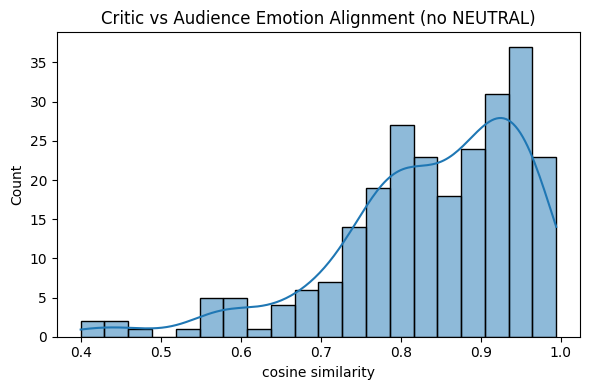

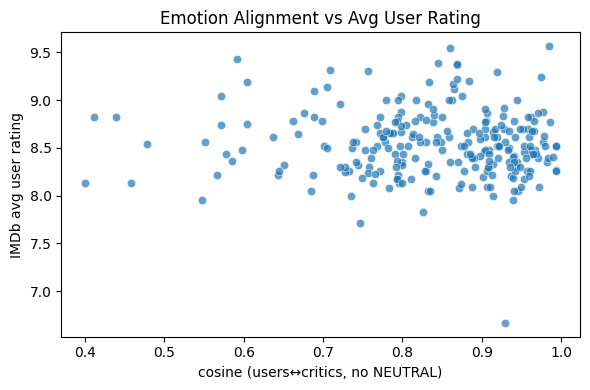

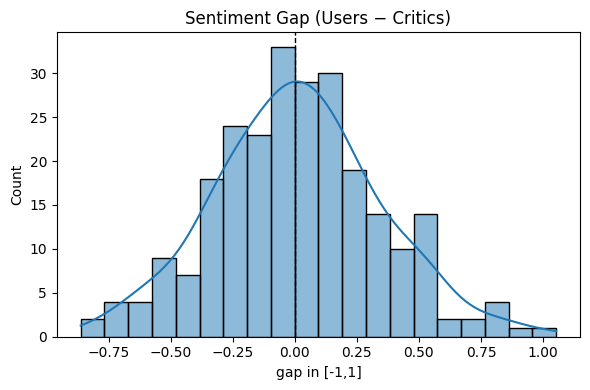

In [48]:
# =====================================
# Cell D — Visuals
# =====================================
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Alignment distribution (non-neutral)
plt.figure(figsize=(6,4))
sns.histplot(alignment["align_emotion_non_neutral"], bins=20, kde=True)
plt.title("Critic vs Audience Emotion Alignment (no NEUTRAL)")
plt.xlabel("cosine similarity"); plt.tight_layout(); plt.show()

# 2) Alignment vs IMDb user rating
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=alignment, x="align_emotion_non_neutral", y="avg_user_rating",
    alpha=0.7
)
plt.title("Emotion Alignment vs Avg User Rating")
plt.xlabel("cosine (users↔critics, no NEUTRAL)")
plt.ylabel("IMDb avg user rating")
plt.tight_layout(); plt.show()

# 3) Sentiment gap
plt.figure(figsize=(6,4))
sns.histplot(alignment["sentiment_gap"], bins=20, kde=True)
plt.title("Sentiment Gap (Users − Critics)")
plt.xlabel("gap in [-1,1]"); plt.axvline(0,color="k",ls="--",lw=1)
plt.tight_layout(); plt.show()
